# Code written by Evan Klein w/ large contributions from Jesse Crawford

In [1]:
import numpy as np
import numpy.lib.recfunctions as rf
import matplotlib.pyplot as plt
from tqdm import tqdm

import astropy.units as u
from astropy.constants import c, h

# Importing bin files and binning data 

## Variable definitions; Change/check all values in this cell for each new data set

In [2]:
folder_path = 'D:/MZI/monochromatic/mono_MZI_6/' # Location of folder data is held in
file_root = 'monochromatic_MZI_' # Start of each file name in folder (Everything up till the numbers)
nfiles = 70 # Total number of data files you have (careful as usually files start counting from 0 not 1)
nbins = 500 # Total number of bins you want data to be separated into (i.e. 70 bins over 70min means 1min per bin)

time_div_label = "min" # Time scale you want to use for plotting choose from: ms, sec, min, hrs, days

display_as_energy = False # Set to True if you want to measure energy instead of photon counts (DON'T USE FOR MULTIPLE WAVELENGTHS)
energy_unit = u.eV # Change to whatever energy units you like in astropy
light_wavelength = 656*u.nm # Measured in nm (disregard if you have multiple wavelengths as stated above)

In [3]:
# Dictionary defining time scale you want to use for plotting
time_div_dict = {"ms" : 1/60, "sec" : 1, "min" : 60, "hrs" : 3600, "days" : 3600*24}
time_div_val = time_div_dict[time_div_label]

### Creating global bins from start timestamp to end timestamp

In [4]:
start_file = folder_path + file_root + str(0) + '.bin'
end_file = folder_path + file_root + str(nfiles-1) + '.bin'

# Creating bin edges to use in data aggregation
start_time = rf.structured_to_unstructured(np.fromfile(start_file, dtype = [('t','q'),('c','h')], offset=40))[1:][0][0]

end_time = rf.structured_to_unstructured(np.fromfile(end_file, dtype = [('t','q'),('c','h')], offset=40))[1:][-1][0]

hist_bins = np.linspace(start_time, end_time, nbins+1) # nbins+1 is to ensure this is bin edges not just centers
hist_bin_centers = (hist_bins[:-1] + hist_bins[1:]) / 2.0 # List of centers of bins (Shorter than bin edges list by 1)

## Iterating through files

In [5]:
hist_vals_1 = np.zeros(nbins)
hist_vals_2 = np.zeros(nbins)

for i in tqdm(range(nfiles)): # tqdm shows a progress bar
    file = folder_path + file_root + str(i) + '.bin' # Each file is its own exposure
    data_arr = rf.structured_to_unstructured(np.fromfile(file, dtype = [('t','q'),('c','h')], offset=40)) # Doing magic to get data from binary file
    data_arr = data_arr[1:] # Trimming first entry in each file as it says its from senor #104???
    
    # Seperating timestamps from single file into two lists
    timestamps_1 = data_arr[np.where(data_arr[:,1]==1)][:,0]
    timestamps_2 = data_arr[np.where(data_arr[:,1]==2)][:,0]
    
    # Aggregating timestamps into global histogram bins
    hist_vals_1 += np.histogram(timestamps_1, bins=hist_bins)[0]
    hist_vals_2 += np.histogram(timestamps_2, bins=hist_bins)[0]

100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [02:17<00:00,  1.96s/it]


### Changing timestamps into real units, and counts into energies if applicable

In [6]:
# Converting bin values from arbitrary timestamps to real time from start of experiment
bin_centers_rt = (np.array(hist_bin_centers) - start_time)/1e12/time_div_val

In [7]:
print(bin_centers_rt[:10], '...\n')
print(f"This list contains {bin_centers_rt.size} elements")

[0.02344088 0.07032264 0.1172044  0.16408616 0.21096792 0.25784969
 0.30473145 0.35161321 0.39849497 0.44537673] ...

This list contains 500 elements


In [8]:
if display_as_energy:
    
    speed_of_light = c.to(u.nm / u.s) # Matching up units
    
    # Energy of one photon in our wavelength (E = hc / λ)
    photon_energy = (h * speed_of_light) / light_wavelength
    photon_energy.to(energy_unit)
    
    hist_vals_energy_1 = hist_vals_1 * photon_energy.value
    hist_vals_energy_2 = hist_vals_2 * photon_energy.value

### No going back to previous cells after running next cell

In [9]:
if display_as_energy:
    hist_vals_1 = hist_vals_energy_1
    hist_vals_2 = hist_vals_energy_2

# Preliminary plot of data

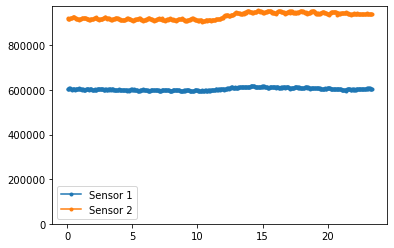

In [10]:
plt.plot(bin_centers_rt, hist_vals_1, marker='.', label='Sensor 1')
plt.plot(bin_centers_rt, hist_vals_2, marker='.', label='Sensor 2')

plt.ylim(bottom=0)

plt.legend()
plt.show()

### Zooming in and normalizing

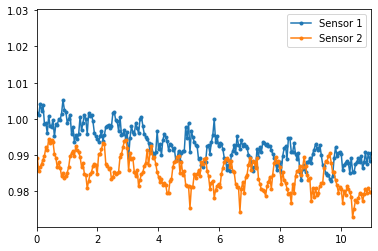

In [11]:
plt.plot(bin_centers_rt, hist_vals_1 / np.average(hist_vals_1), marker='.', label='Sensor 1')
plt.plot(bin_centers_rt, hist_vals_2 / np.average(hist_vals_2), marker='.', label='Sensor 2')

plt.xlim(0, 11)

plt.legend()
plt.show()

# Cosine fitting

In [12]:
from scipy.optimize import curve_fit

In [13]:
def cosine_func(x, amplitude, period, phase, offset, slope):
    return amplitude*np.cos(2*np.pi*(x/period-phase))+ offset + slope*x

## Replace all values of period, phase shift, and slope in this cell by visual guesses

In [14]:
# Initial guess for amplitude, period, phase shift, offset, and slope 
# Period between peaks in real time units, and phase shift from normal cosine function in radians from -2π to +2π
initial_guess_1 = (max(hist_vals_1)-np.average(hist_vals_1), 0.8, -np.pi/2, np.average(hist_vals_1), -0.09)
initial_guess_2 = (max(hist_vals_2)-np.average(hist_vals_2), 0.8, +np.pi/2, np.average(hist_vals_2), -0.09)

In [15]:
# Times you want the modeling to start and end at (measured in minutes, seconds, etc.)
model_start = 0
model_end = 10

In [16]:
# Finding closest index in bin_centers_rt array to above values
start_index = np.argmin(np.abs(bin_centers_rt-model_start))
end_index = np.argmin(np.abs(bin_centers_rt-model_end))

print(start_index, end_index)

0 213


In [17]:
best_vals_1, covar_1 = curve_fit(cosine_func, bin_centers_rt[start_index:end_index], hist_vals_1[start_index:end_index], p0=initial_guess_1)
best_vals_2, covar_2 = curve_fit(cosine_func, bin_centers_rt[start_index:end_index], hist_vals_2[start_index:end_index], p0=initial_guess_2)

print(best_vals_1)
print(best_vals_2)

[ 1.90880552e+03  8.27995370e-01 -1.91574985e+00  6.04398969e+05
 -7.72102948e+02]
[ 3.96676074e+03  8.30296329e-01  1.54888778e+00  9.20849998e+05
 -6.06431301e+02]


In [18]:
# Uncertainties in model parameters are the square roots of the diagonals of the covariance matrix
model_unc_1 = np.sqrt([covar_1[i][i] for i in range(covar_1.shape[0])])
model_unc_2 = np.sqrt([covar_2[i][i] for i in range(covar_2.shape[0])])

print(model_unc_1)
print(model_unc_2)

[1.12399239e+02 2.25092028e-03 1.90136066e-02 1.59486989e+02
 2.76710827e+01]
[1.61308787e+02 1.55793676e-03 1.30745117e-02 2.28744079e+02
 3.96803533e+01]


In [19]:
# List of y-values created from model parameters
model_1 = cosine_func(bin_centers_rt, *best_vals_1)
model_2 = cosine_func(bin_centers_rt, *best_vals_2)

## Rounding model parameters to proper amount of sigfigs

In [20]:
import math
def get_exp(number):
    return int(math.floor(math.log10(abs(number))))

In [21]:
best_vals_round_1 = np.array([])
best_vals_round_2 = np.array([])
model_unc_round_1 = np.array([])
model_unc_round_2 = np.array([])

for i in range(len(best_vals_1)):
    sigfig_1 = get_exp(model_unc_1[i])
    sigfig_2 = get_exp(model_unc_2[i])
    
    # Rounding values to proper sigfigs
    val_round_1 = np.round(best_vals_1[i], decimals=-sigfig_1)
    val_round_2 = np.round(best_vals_2[i], decimals=-sigfig_2)
    unc_round_1 = np.round(model_unc_1[i], decimals=-sigfig_1)
    unc_round_2 = np.round(model_unc_2[i], decimals=-sigfig_2)
      
    best_vals_round_1 = np.append(best_vals_round_1, val_round_1)
    model_unc_round_1 = np.append(model_unc_round_1, unc_round_1)
    best_vals_round_2 = np.append(best_vals_round_2, val_round_2)
    model_unc_round_2 = np.append(model_unc_round_2, unc_round_2)

print(best_vals_round_1)
print(model_unc_round_1)
print(best_vals_round_2)
print(model_unc_round_2)

[ 1.900e+03  8.280e-01 -1.920e+00  6.044e+05 -7.700e+02]
[1.e+02 2.e-03 2.e-02 2.e+02 3.e+01]
[ 4.000e+03  8.300e-01  1.550e+00  9.208e+05 -6.100e+02]
[2.e+02 2.e-03 1.e-02 2.e+02 4.e+01]


## Plot of original data and models

In [22]:
plot_text = f'''Sensor 1 best fit:
            Amplitude: {best_vals_round_1[0]}±{model_unc_round_1[0]}, Period: {best_vals_round_1[1]}±{model_unc_round_1[1]}, 
            Phase shift: {best_vals_round_1[2]/np.pi:.2f}π±{model_unc_round_1[2]/np.pi:.2f}π, Offset: {best_vals_round_1[3]}±{model_unc_round_1[3]},
            Slope: {best_vals_round_1[4]}±{model_unc_round_1[4]}\n
            Sensor 2 best fit:
            Amplitude: {best_vals_round_2[0]}±{model_unc_round_2[0]}, Period: {best_vals_round_2[1]}±{model_unc_round_2[1]}, 
            Phase shift: {best_vals_round_2[2]/np.pi:.2f}π±{model_unc_round_2[2]/np.pi:.2f}π, Offset: {best_vals_round_2[3]}±{model_unc_round_2[3]},
            Slope: {best_vals_round_2[4]}±{model_unc_round_2[4]}'''

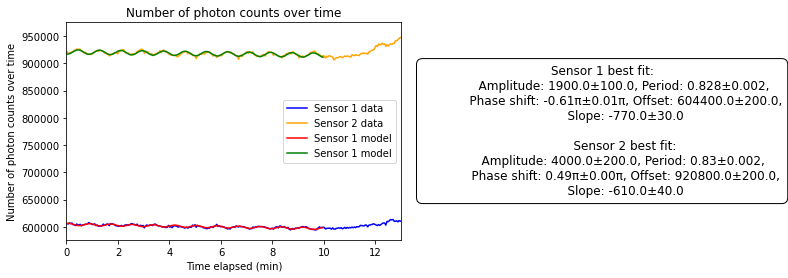

In [29]:
plt.plot(bin_centers_rt, hist_vals_1, label="Sensor 1 data", color='Blue')
plt.plot(bin_centers_rt, hist_vals_2, label="Sensor 2 data", color='Orange')

# Plotting models with parameters in labels
plt.plot(bin_centers_rt[start_index:end_index], model_1[start_index:end_index], label="Sensor 1 model", color='Red')
plt.plot(bin_centers_rt[start_index:end_index], model_2[start_index:end_index], label="Sensor 1 model", color='Green')

plt.xlim(model_start-1, model_end+1)

xlim = plt.xlim()
ylim = plt.ylim()
text_x = xlim[1] + (xlim[1] - xlim[0]) * .6  # Adjust as needed
text_y = (ylim[0] + ylim[1]) / 2

# Add text box to the plot
plt.text(text_x, text_y, plot_text, verticalalignment='center', horizontalalignment='center', fontsize=12,
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.title(f"Energy ({energy_unit}) over time" if display_as_energy else "Number of photon counts over time")
plt.xlabel(f"Time elapsed ({time_div_label})")
plt.ylabel(f"Energy ({energy_unit})" if display_as_energy else "Number of photon counts over time")

plt.legend()
plt.show()

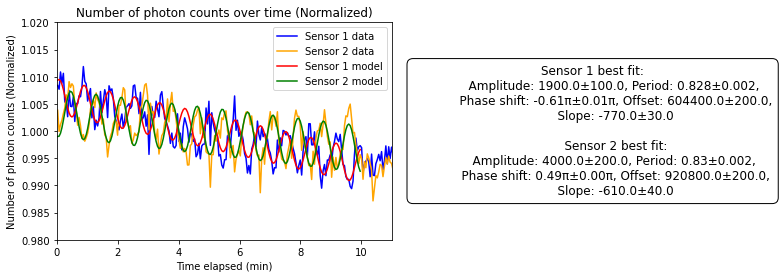

In [33]:
plt.plot(bin_centers_rt, hist_vals_1 / np.average(model_1[start_index:end_index]), label="Sensor 1 data", color='Blue')
plt.plot(bin_centers_rt, hist_vals_2 / np.average(model_2[start_index:end_index]), label="Sensor 2 data", color='Orange')

# Plotting models with parameters in labels
plt.plot(bin_centers_rt[start_index:end_index], model_1[start_index:end_index] / np.average(model_1[start_index:end_index]),
         label="Sensor 1 model", color='Red')
plt.plot(bin_centers_rt[start_index:end_index], model_2[start_index:end_index] / np.average(model_2[start_index:end_index]),
         label="Sensor 2 model", color='Green')

plt.xlim(model_start-1, model_end+1)
plt.ylim(0.98, 1.02)

xlim = plt.xlim()
ylim = plt.ylim()
text_x = xlim[1] + (xlim[1] - xlim[0]) * .6  # Adjust as needed
text_y = (ylim[0] + ylim[1]) / 2

# Add text box to the plot
plt.text(text_x, text_y, plot_text, verticalalignment='center', horizontalalignment='center', fontsize=12,
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.title(f"Energy ({energy_unit}) over time (Normalized)" if display_as_energy else "Number of photon counts over time (Normalized)")
plt.xlabel(f"Time elapsed ({time_div_label})")
plt.ylabel(f"Energy ({energy_unit}) Normalized" if display_as_energy else "Number of photon counts (Normalized)")

plt.legend()
plt.show()

# Residuals

In [25]:
# Residual = Observed - Predicted
residual_1 = hist_vals_1[start_index:end_index] - model_1[start_index:end_index]
residual_2 = hist_vals_2[start_index:end_index] - model_2[start_index:end_index]

residual_frac_1 = residual_1 / model_1[start_index:end_index]
residual_frac_2 = residual_2 / model_2[start_index:end_index]

# Chi^2
chi_1 = np.sum(residual_1**2 / model_1[start_index:end_index])
chi_2 = np.sum(residual_2**2 / model_2[start_index:end_index])

print(chi_1, chi_2)

467.1191631616854 628.9134916869066


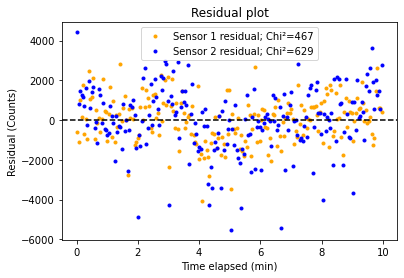

In [26]:
plt.plot(bin_centers_rt[start_index:end_index], residual_1, 
         label=f"Sensor 1 residual; Chi²={np.round(chi_1).astype(int)}", color='Orange', marker='.', ls='None')
plt.plot(bin_centers_rt[start_index:end_index], residual_2, 
         label=f"Sensor 2 residual; Chi²={np.round(chi_2).astype(int)}", color='Blue', marker='.', ls='None')
plt.axhline(y=0, color='black', linestyle='--')

plt.legend()

plt.title(f"Residual plot")
plt.xlabel(f"Time elapsed ({time_div_label})")
plt.ylabel(f"Residual (Energy {energy_unit})" if display_as_energy else f"Residual (Counts)")

plt.show()

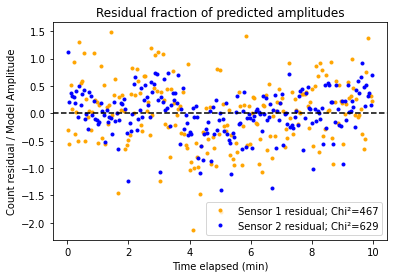

In [27]:
plt.plot(bin_centers_rt[start_index:end_index], residual_1/best_vals_1[0], label=f"Sensor 1 residual; Chi²={np.round(chi_1).astype(int)}", color='Orange', marker='.', ls='None')
plt.plot(bin_centers_rt[start_index:end_index], residual_2/best_vals_2[0], label=f"Sensor 2 residual; Chi²={np.round(chi_2).astype(int)}", color='Blue', marker='.', ls='None')
plt.axhline(y=0, color='black', linestyle='--')

plt.legend()

plt.title(f"Residual fraction of predicted amplitudes")
plt.xlabel(f"Time elapsed ({time_div_label})")
plt.ylabel(f"Energy {energy_unit} residual / Model Amplitude" if display_as_energy else f"Count residual / Model Amplitude")

plt.show()

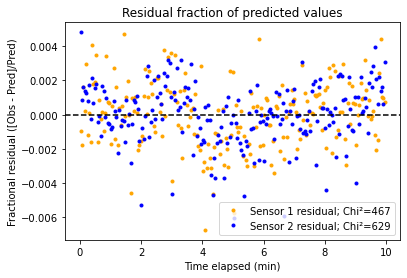

In [28]:
plt.plot(bin_centers_rt[start_index:end_index], residual_frac_1, label=f"Sensor 1 residual; Chi²={np.round(chi_1).astype(int)}", color='Orange', marker='.', ls='None')
plt.plot(bin_centers_rt[start_index:end_index], residual_frac_2, label=f"Sensor 2 residual; Chi²={np.round(chi_2).astype(int)}", color='Blue', marker='.', ls='None')
plt.axhline(y=0, color='black', linestyle='--')

plt.legend()

plt.title(f"Residual fraction of predicted values")
plt.xlabel(f"Time elapsed ({time_div_label})")
plt.ylabel(f"Fractional residual ([Obs - Pred]/Pred)")

plt.show()